# Home Loan Approval Prediction Project




## 1. Import Libraries and Load Data

In [37]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from imblearn.over_sampling import SMOTE
from google.colab import files
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier

In [38]:
# Load the dataset, specifying the raw file URL
train = pd.read_csv('https://raw.githubusercontent.com/TonyNguyenK1/Capston-Project-820/main/Datasets/loan_sanction_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/TonyNguyenK1/Capston-Project-820/main/Datasets/loan_sanction_test.csv')

## 2. Initial Inspection

### 2.1. Analyzing the Data

**Train Dataset**

In [39]:
train.shape

(614, 13)

In [40]:
train.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area,Loan_Status
0,LP001002,Male,No,0,Graduate,No,5849,0.0,NaN,360.0,1.0,Urban,Y
1,LP001003,Male,Yes,1,Graduate,No,4583,1508.0,128.0,360.0,1.0,Rural,N
2,LP001005,Male,Yes,0,Graduate,Yes,3000,0.0,66.0,360.0,1.0,Urban,Y
3,LP001006,Male,Yes,0,Not Graduate,No,2583,2358.0,120.0,360.0,1.0,Urban,Y
4,LP001008,Male,No,0,Graduate,No,6000,0.0,141.0,360.0,1.0,Urban,Y


**Test Dataset**

In [41]:
test.shape

(367, 12)

In [42]:
test.head()

,Loan_ID,Gender,Married,Dependents,Education,Self_Employed,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Property_Area
0,LP001015,Male,Yes,0,Graduate,No,5720,0,110.0,360.0,1.0,Urban
1,LP001022,Male,Yes,1,Graduate,No,3076,1500,126.0,360.0,1.0,Urban
2,LP001031,Male,Yes,2,Graduate,No,5000,1800,208.0,360.0,1.0,Urban
3,LP001035,Male,Yes,2,Graduate,No,2340,2546,100.0,360.0,NaN,Urban
4,LP001051,Male,No,0,Not Graduate,No,3276,0,78.0,360.0,1.0,Urban


### 2.2. Missing Values

In [43]:
# Listing the count of missing values for each feature.
train.isnull().sum()


Loan_ID               0
Gender               13
Married               3
Dependents           15
Education             0
Self_Employed        32
ApplicantIncome       0
CoapplicantIncome     0
LoanAmount           22
Loan_Amount_Term     14
Credit_History       50
Property_Area         0
Loan_Status           0
dtype: int64

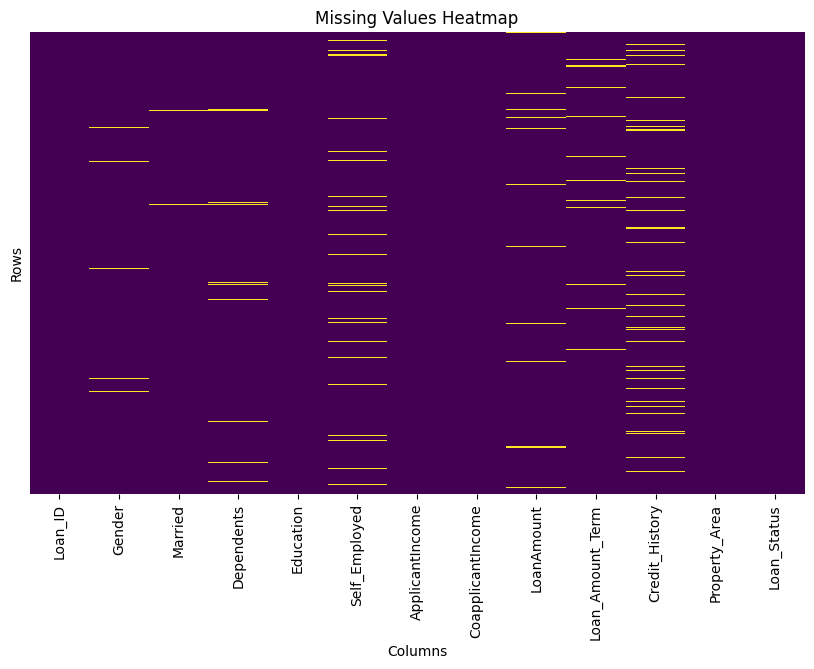

In [44]:
# Plotting the missing values heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(train.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.xlabel('Columns')
plt.ylabel('Rows')
plt.title('Missing Values Heatmap')
plt.show()

## 3. Exploratory Data Analysis (EDA)

### 3.1. Statistics Summary

In [45]:
# Get summary statistics for numerical features
numerical_features = ['ApplicantIncome', 'CoapplicantIncome', 'LoanAmount', 'Loan_Amount_Term']
numerical_summary = train[numerical_features].describe()
numerical_summary

,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term
count,614.000000,614.000000,592.000000,600.00000
mean,5403.459283,1621.245798,146.412162,342.00000
std,6109.041673,2926.248369,85.587325,65.12041
min,150.000000,0.000000,9.000000,12.00000
25%,2877.500000,0.000000,100.000000,360.00000
50%,3812.500000,1188.500000,128.000000,360.00000
75%,5795.000000,2297.250000,168.000000,360.00000
max,81000.000000,41667.000000,700.000000,480.00000


### 3.2. Univariate Analysis

* Income: Both applicant and co-applicant incomes show significant variation with some high-income outliers. This suggests the need for scaling and possibly transforming these variables.

* Loan Amount and Term: The loan amount also varies widely, indicating that some applicants request significantly larger loans. The loan term is mostly consistent, with 360 months being a common value.

* Categorical Variables: There are clear trends in the categorical variables, such as more male applicants, more married applicants, and a higher number of graduates. The approval rate is higher for those with a credit history.


#### 3.1.1. Distribution of numerical features.

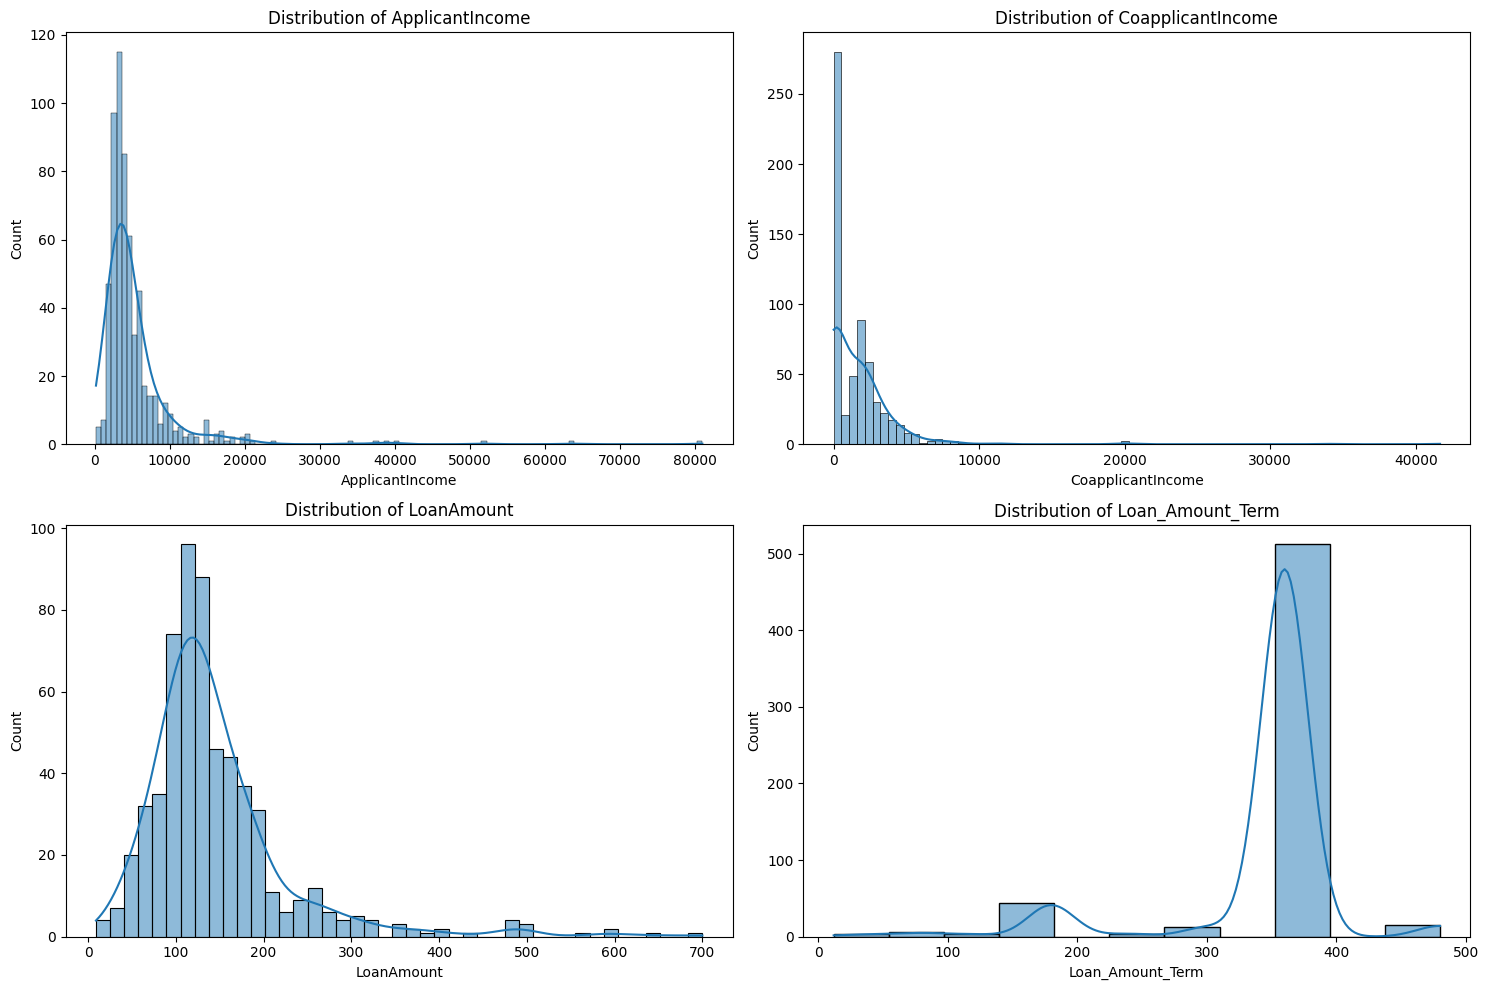

In [46]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features, 1):
    plt.subplot(2, 2, i)
    sns.histplot(train[feature].dropna(), kde=True)
    plt.title(f'Distribution of {feature}')
plt.tight_layout()
plt.show()

*   Applicant Income: The distribution is right-skewed with a few high-income outliers.
*   Co-applicant Income: The distribution is also right-skewed with many zero values indicating no co-applicant.
*   Loan Amount: The distribution is right-skewed with higher values extending the tail.
*   Loan Amount Term: The distribution shows common values like 360 months representing standard loan terms

#### 3.1.2. Frequency counts and bar plots for categorical features

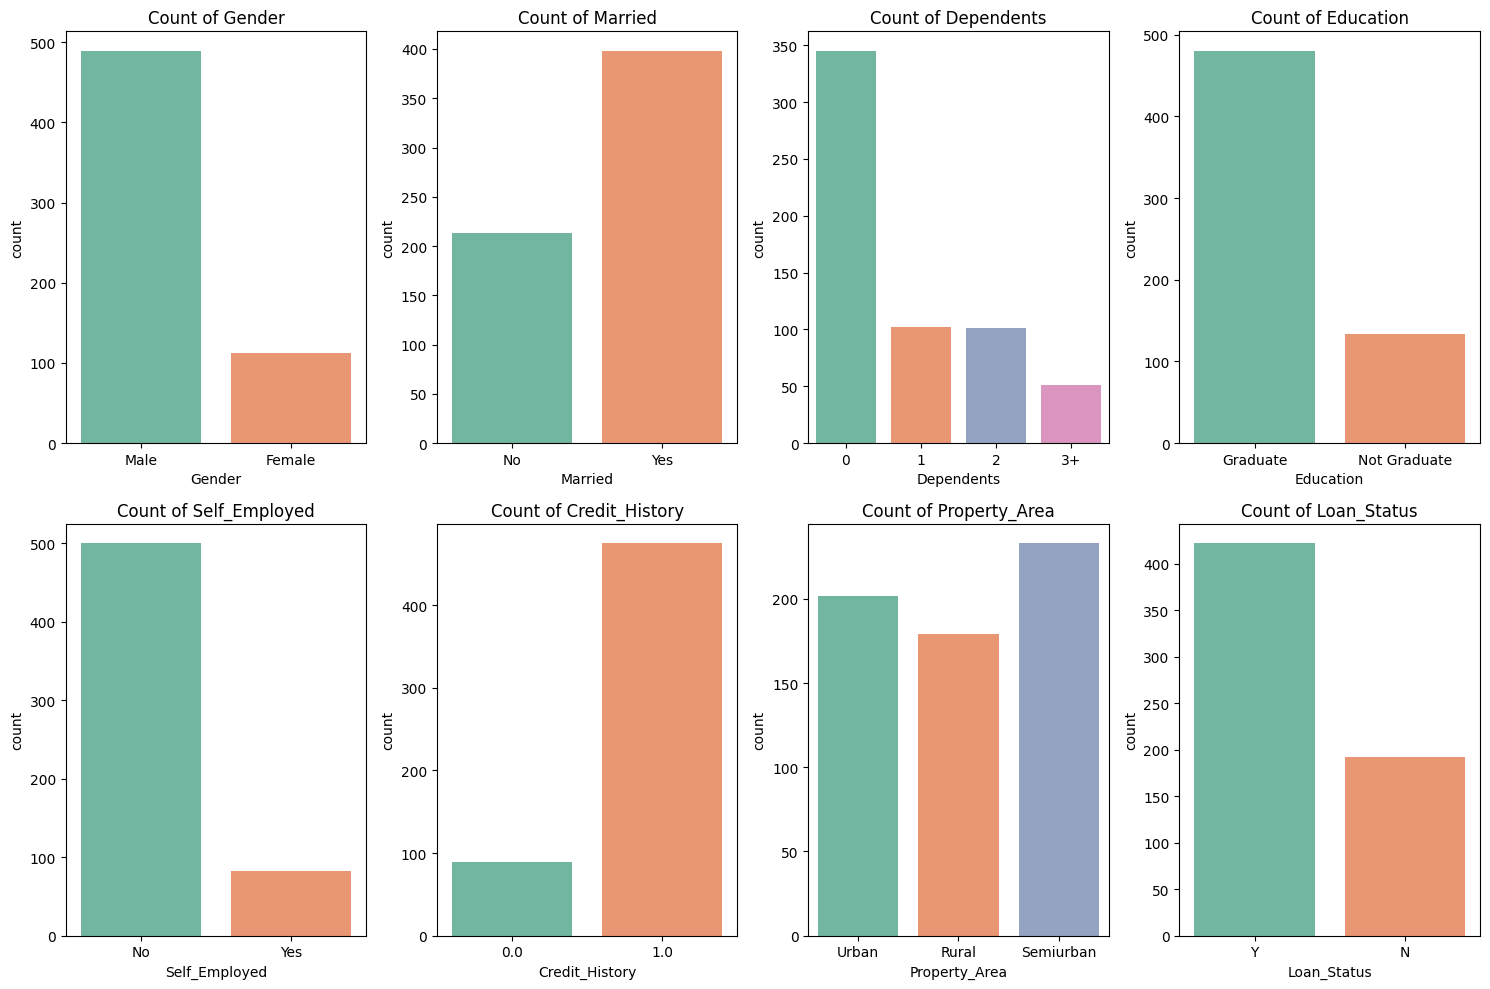

In [47]:
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area', 'Loan_Status']

plt.figure(figsize=(15,10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 4, i)
    sns.countplot(x=feature, data=train, hue=feature, palette="Set2", legend=False)
    plt.title(f'Count of {feature}')
plt.tight_layout()
plt.show()

*   Gender: Majority of applicants are male.
*   Dependents: Most applicants have zero dependents
*   Married: More applicants are married than unmarried.
*   Education: Majority of applicants are graduates.
*   Self_Employed: Most applicants are not self-employed.
*   Credit History: Majority of applicants have a credit history.
*   Property Area: Semi urban properties are the most common.
*   Loan Status: More loans are approved than rejected.

### 3.3. Bivariate Analysis

*   Income and Loan Amount: Higher applicant and co-applicant incomes are associated with higher loan amounts and higher approval rates.
*   Credit History: Presence of credit history significantly increases the likelihood of loan approval.
Demographic Factors: Married, male, graduate, and non-self-employed applicants are more likely to be approved.
*   Dependents: Fewer dependents correlate with higher approval rates.
*   Property Area: Semiurban areas have the highest approval rates, suggesting possibly lower risk associated with these locations.

#### 3.2.1. Numerical Features vs. Loan Status

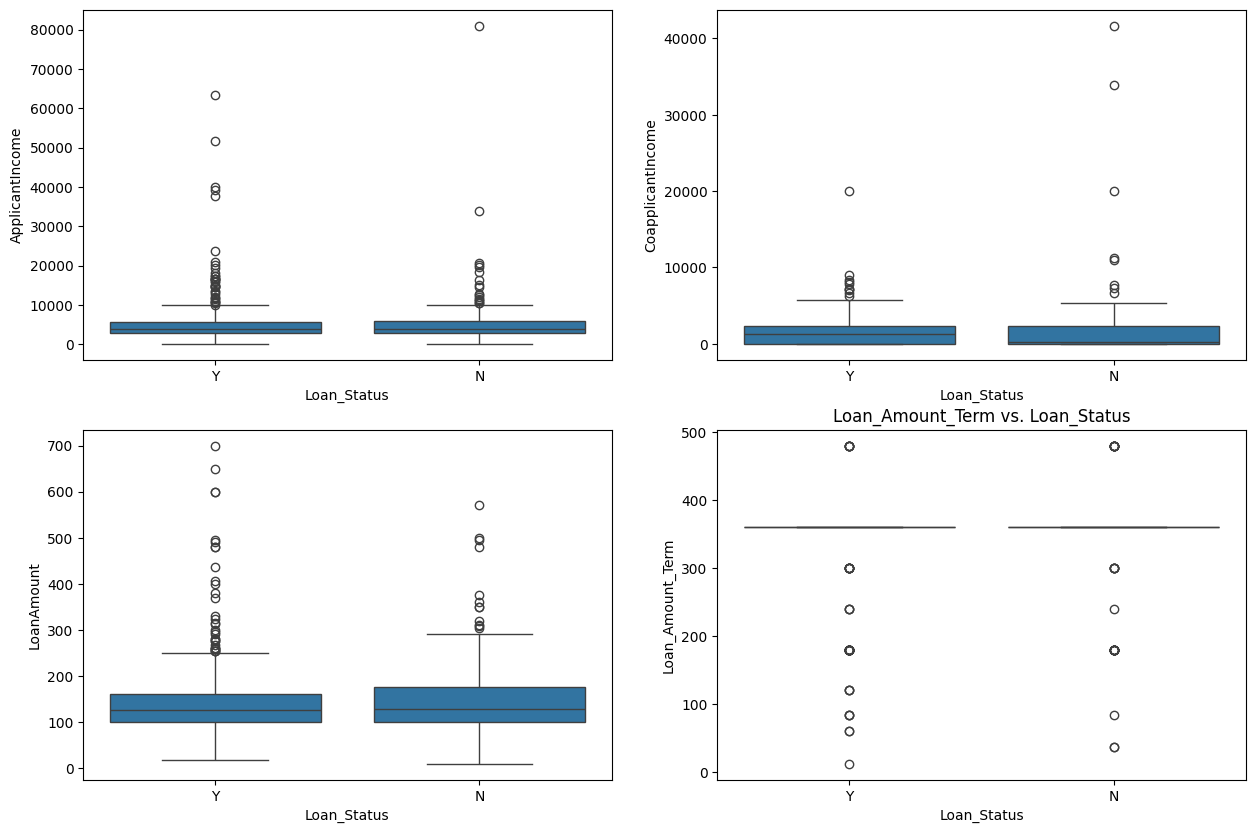

In [48]:
plt.figure(figsize=(15, 10))
for i, feature in enumerate(numerical_features,1):
      plt.subplot(2, 2, i)
      sns.boxplot(x='Loan_Status', y=feature, data=train)
plt.title(f'{feature} vs. Loan_Status')
plt.show()

*   **Applicant Income vs. Loan Status**: The box plot shows that the median applicant income is slightly higher for approved loans compared to rejected loans. However, there are significant outliers in both groups.
*  **Co-applicant Income vs. Loan Status**: The median co-applicant income is higher for approved loans. Zero incomes are more common among rejected loans.
*   **Loan Amount vs. Loan Status**: Approved loans tend to have a higher median loan amount compared to rejected loans, with fewer extreme outliers in the rejected group.
*   **Loan Amount Term vs. Loan Status**: The loan amount term ***does not show a significant difference*** between approved and rejected loans, with 360 months being the most common term in both cases.

#### 3.2.2. Categorical Features vs. Loan Status

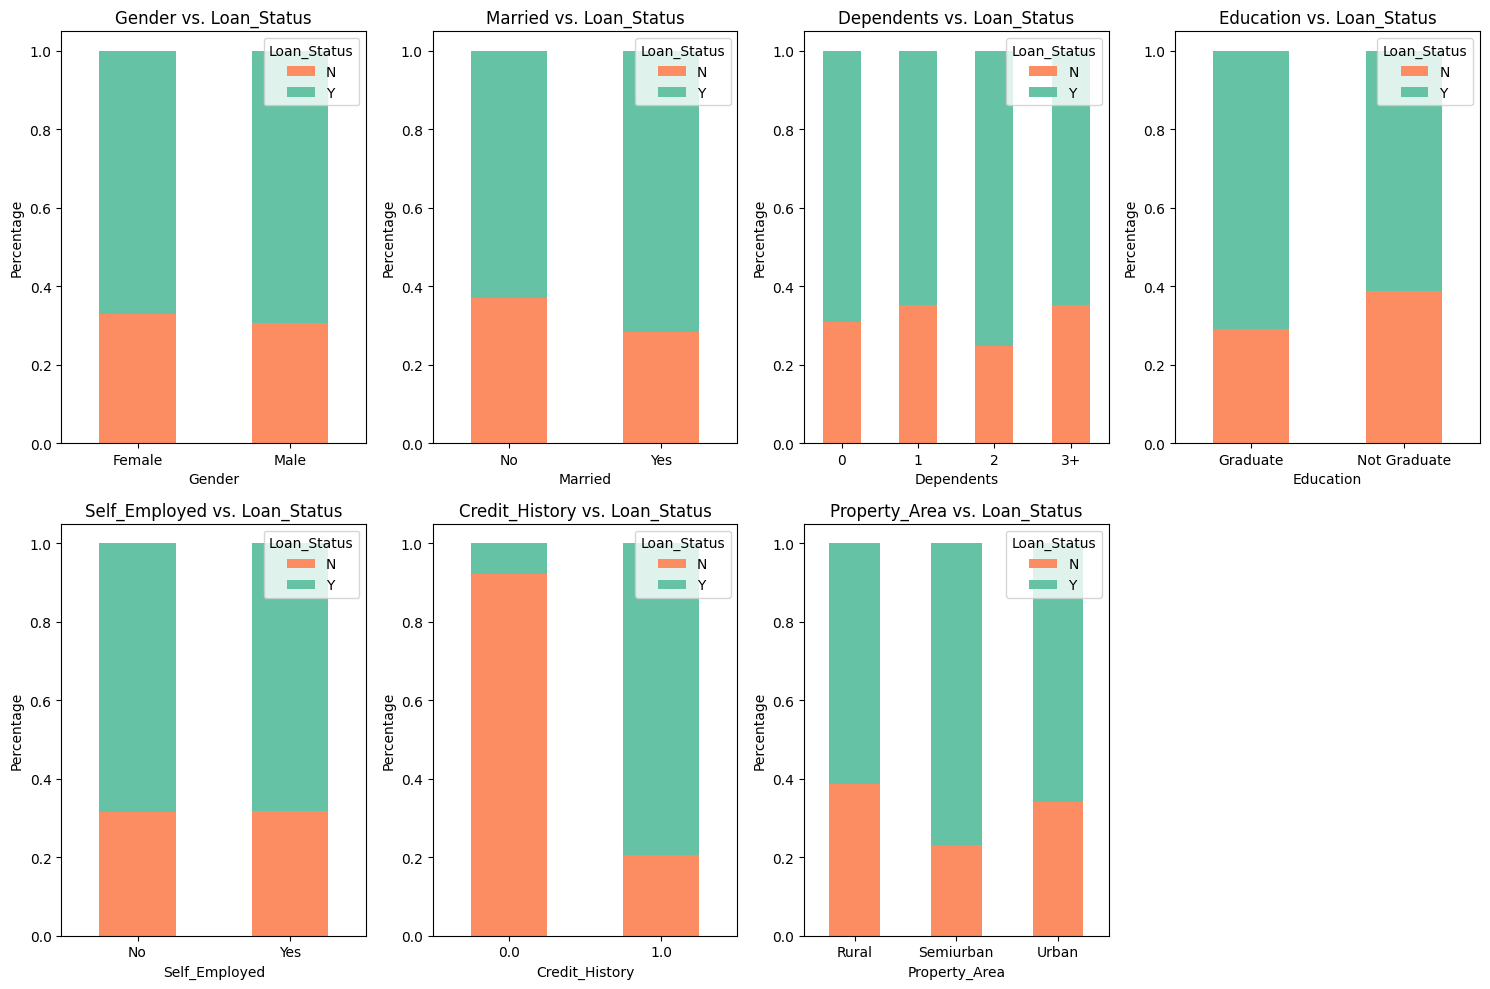

In [49]:
# Categorical features
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Credit_History', 'Property_Area']

# Plot bivariate analysis for categorical features
plt.figure(figsize=(15, 10))
for i, feature in enumerate(categorical_features, 1):
    plt.subplot(2, 4, i)
    crosstab = pd.crosstab(train[feature], train['Loan_Status'])
    crosstab_percentage = crosstab.div(crosstab.sum(1).astype(float), axis=0)
    crosstab_percentage.plot(kind="bar", stacked=True, ax=plt.gca(), color=sns.color_palette("Set2",2)[::-1])
    plt.title(f'{feature} vs. Loan_Status')
    plt.xticks(rotation=0)
    plt.xlabel(feature)
    plt.ylabel('Percentage')
    plt.title(f'{feature} vs. Loan_Status')

plt.tight_layout()
plt.show()




The loan approval rates are as follows:

* Gender: Both males and females have similar approval rates, with no significant difference between the two.
* Marital Status: Married applicants have a slightly higher approval rate than non-married applicants.
* Dependents: Applicants with no dependents have the highest approval rate. As the number of dependents increases, the approval rate decreases, with those having 3 or more dependents showing the lowest rate.
* Education: Graduates have a higher approval rate compared to non-graduates.
* Employment Status: Non-self-employed individuals have a slightly higher approval rate compared to self-employed individuals.
* Credit History: Applicants with a positive credit history have a significantly higher approval rate compared to those without a credit history.
* Location: Applicants from semi-urban areas have the highest approval rate. Urban area applicants have a moderate approval rate, while those from rural areas have the lowest approval rate.

### 3.4. Correlation Analysis for Numerical Features

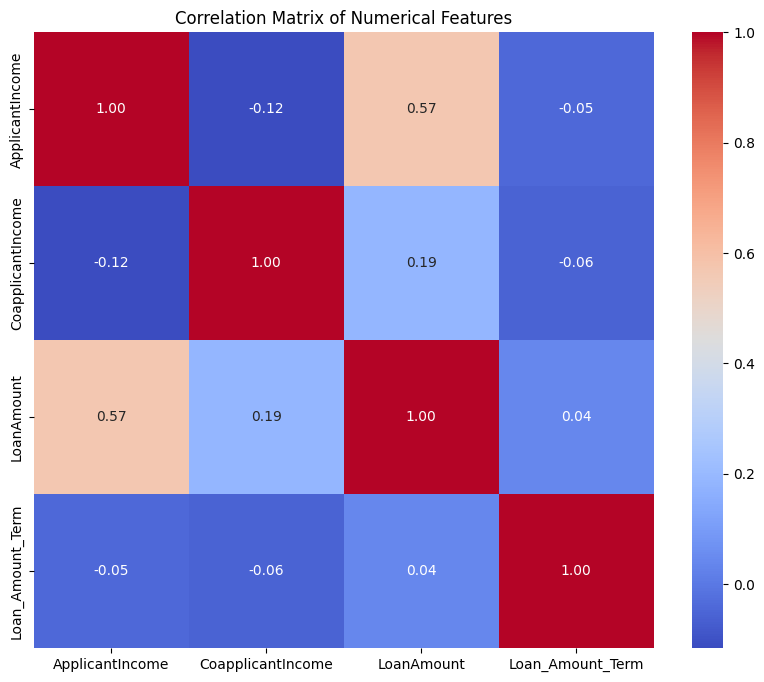

In [50]:
correlation_matrix = train[numerical_features].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numerical Features')
plt.show()

The correlation matrix for numerical features shows the following key points:
*   Applicant Income and Loan Amount: There is a moderate positive correlation (0.57) between applicant income and loan amount, indicating that higher income applicants tend to request higher loan amounts.

*   Coapplicant Income and Loan Amount: There is a weaker positive correlation (0.19) between coapplicant income and loan amount.

*   Applicant Income and Coapplicant Income: There is a slight negative correlation (-0.12) between applicant income and coapplicant income, suggesting that often, when one is high, the other tends to be lower.

*   Loan Amount Term: There is very little correlation between loan amount term and other numerical features.


## 4. Data Preprocessing




### 4.1 Handling Missing Values

There are missing values in the **'Gender', 'Married', 'Dependents', 'Self_Employed', 'LoanAmount', 'Loan_Amount_Term'**, and **'Credit_History'** features. We will treat the missing values in all the features one by one using the following methods:

*   For numerical variables: Imputation using mean or median
*   For categorical variables: Imputation using mode

**Gender, Married, Dependents, Credit_History**, and **Self_Employed**: These features have very few missing values, so we will fill them using the mode of the respective features.

**Loan_Amount** and **Loan_Amount_Term**: We will use median imputation for LoanAmount and mode imputation for Loan_Amount_Term.

In [51]:
# Handle Missing Values
def handle_missing_values(df):
    df['Gender'].fillna(df['Gender'].mode()[0], inplace=True)
    df['Married'].fillna(df['Married'].mode()[0], inplace=True)
    df['Dependents'].fillna(df['Dependents'].mode()[0], inplace=True)
    df['Self_Employed'].fillna(df['Self_Employed'].mode()[0], inplace=True)
    df['Credit_History'].fillna(df['Credit_History'].mode()[0], inplace=True)
    df['Loan_Amount_Term'].fillna(df['Loan_Amount_Term'].mode()[0], inplace=True)
    df['LoanAmount'].fillna(df['LoanAmount'].median(), inplace=True)
    return df

# All the missing values have been addressed in the train dataset. Let's apply the same method to fill in the missing values in the test dataset as well.
train = handle_missing_values(train)
test = handle_missing_values(test)


### 4.2. Handling Outlier

Outliers can skew the results and reduce the accuracy of our models. From the ealier Correlation Matrix, we observed the **Loan_amount_term** has very little correlation with other numerical features. Therefore, We will focus on identifying and handling outliers in the numerical features of the dataset, particularly **ApplicantIncome, CoapplicantIncome, and LoanAmount**.

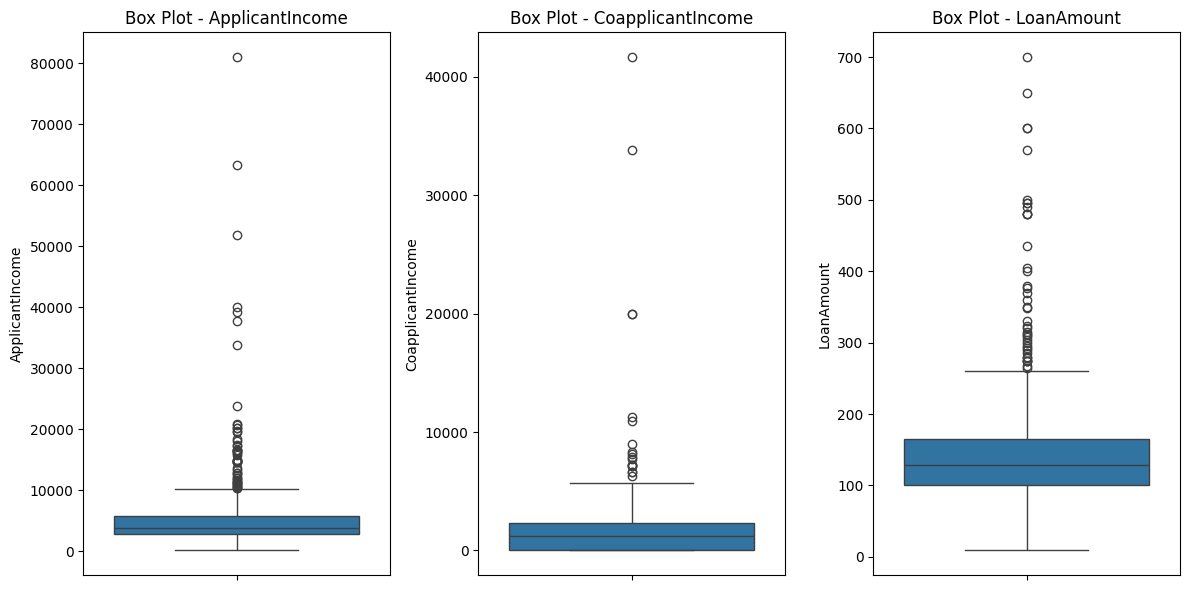

In [52]:
# Visualize the distribution and outliers of numerical features using boxplot
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.boxplot(y=train['ApplicantIncome'])
plt.title('Box Plot - ApplicantIncome')

plt.subplot(1, 3, 2)
sns.boxplot(y=train['CoapplicantIncome'])
plt.title('Box Plot - CoapplicantIncome')

plt.subplot(1, 3, 3)
sns.boxplot(y=train['LoanAmount'])
plt.title('Box Plot - LoanAmount')

plt.tight_layout()
plt.show()

**'ApplicantIncome'** There are numerous outliers that are significantly higher than the bulk of the data, with the maximum value around 80,000. This indicates that ApplicantIncome has a right-skewed distribution and many extreme values (outliers).

**'CoapplicantIncome'** also has many outliers, similar to ApplicantIncome,  with the maximum value around 40,000. The distribution of CoapplicantIncome is also right-skewed with many extreme values.

**'LoanAmount'** also has numerous outliers, with the maximum value around 700. The distribution of LoanAmount is right-skewed and contains many extreme values.

Given the observations above, all three variables have many outliers. Therefore, it is essential to apply outlier treatment methods to mitigate their negative impact on the model.

**Clipping outliers** to the whiskers of the boxplot will cap extreme values to a more reasonable range and can help stabilize your model's performance. Let's apply this method to ApplicantIncome, CoapplicantIncome, and LoanAmount




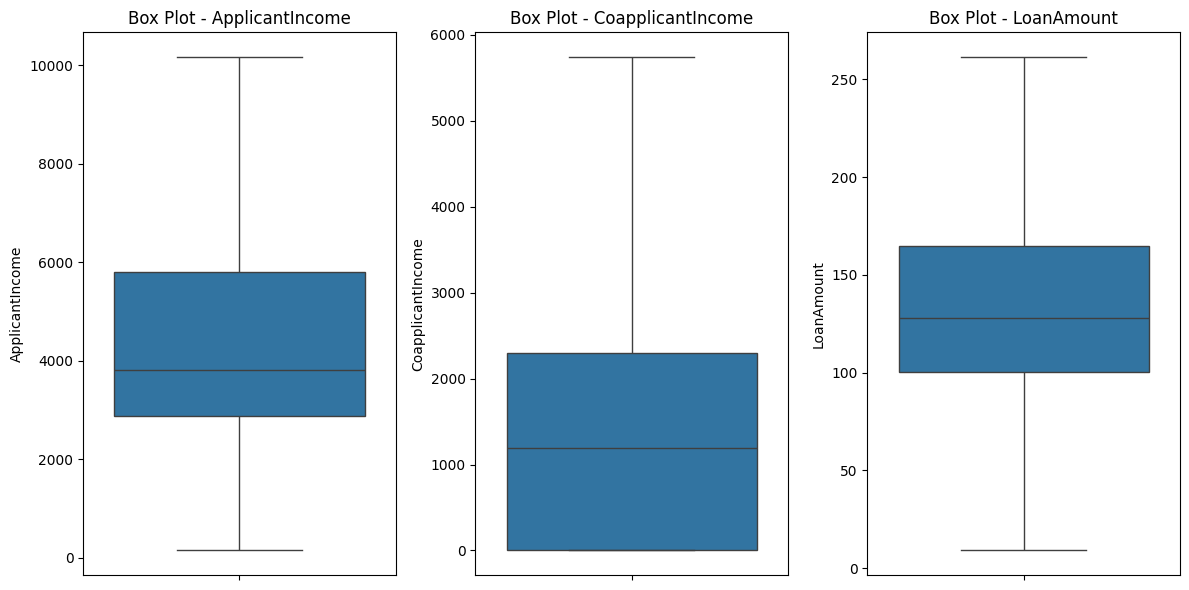

In [53]:
# Function to handle outliers by clipping them to the whiskers
def handle_outliers(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].apply(lambda x: lower_bound if x < lower_bound else upper_bound if x > upper_bound else x)
    return df

# Apply clipping to ApplicantIncome, CoapplicantIncome, and LoanAmount
train = handle_outliers(train, 'ApplicantIncome')
train = handle_outliers(train, 'CoapplicantIncome')
train = handle_outliers(train, 'LoanAmount')
plt.figure(figsize=(12, 6))

plt.subplot(1, 3, 1)
sns.boxplot(y=train['ApplicantIncome'])
plt.title('Box Plot - ApplicantIncome')


plt.subplot(1, 3, 2)
sns.boxplot(y=train['CoapplicantIncome'])
plt.title('Box Plot - CoapplicantIncome')

plt.subplot(1, 3, 3)
sns.boxplot(y=train['LoanAmount'])
plt.title('Box Plot - LoanAmount')

plt.tight_layout()
plt.show()

### 4.3 Standardize numerical features


Use StandardScaler from sklearn.preprocessing to standardize the numerical features in both the training and test datasets.

In [54]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Scale the numerical features
train[numerical_features] = scaler.fit_transform(train[numerical_features])
test[numerical_features] = scaler.transform(test[numerical_features])

### 4.4. Encode categories variables

In [55]:
# One-hot encode the categorical features
categorical_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 'Property_Area']
train = pd.get_dummies(train, columns=categorical_features)
test = pd.get_dummies(test, columns=categorical_features)

# Ensure the same columns are in both train and test datasets
train, test = train.align(test, join='left', axis=1)
test = test.fillna(0)

In [56]:
train.head()

,Loan_ID,ApplicantIncome,CoapplicantIncome,LoanAmount,Loan_Amount_Term,Credit_History,Loan_Status,Gender_Female,Gender_Male,Married_No,...,Dependents_1,Dependents_2,Dependents_3+,Education_Graduate,Education_Not Graduate,Self_Employed_No,Self_Employed_Yes,Property_Area_Rural,Property_Area_Semiurban,Property_Area_Urban
0,LP001002,0.497164,-0.874587,-0.168041,0.273231,1.0,Y,False,True,True,...,False,False,False,True,False,True,False,False,False,True
1,LP001003,-0.013767,0.054395,-0.168041,0.273231,1.0,N,False,True,False,...,True,False,False,True,False,True,False,True,False,False
2,LP001005,-0.652632,-0.874587,-1.280462,0.273231,1.0,Y,False,True,False,...,False,False,False,True,False,False,True,False,False,True
3,LP001006,-0.820924,0.578025,-0.311579,0.273231,1.0,Y,False,True,False,...,False,False,False,False,True,True,False,False,False,True
4,LP001008,0.558104,-0.874587,0.065209,0.273231,1.0,Y,False,True,True,...,False,False,False,True,False,True,False,False,False,True


## 5. Split Data into Training and Validation Sets

Separate the target variable 'Loan_status' and the features. Drop the column 'Loan_ID'.

Use train_test_split from sklearn.model_selection to split the dataset into training and validation sets.

In [57]:
# Define the target variable and features
X = train.drop(columns=['Loan_Status', 'Loan_ID'])
y = train['Loan_Status'].apply(lambda x: 1 if x == 'Y' else 0)

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)

print("Training set shape:", X_train.shape)
print("Validation set shape:", X_val.shape)

Training set shape: (429, 20)
Validation set shape: (185, 20)


## 6. Build and Evaluate Models Using Cross-Validation

We'll build three models (Logistic Regression, K-Nearest Neighbors, and Decision Tree) and evaluate their performance using cross-validation.
Using cross_val_score to evaluate the model using 10-fold cross-validation with roc_auc as the scoring metric.

In [58]:
# Initialize the models
logreg = LogisticRegression(max_iter=1000)
knn = KNeighborsClassifier(n_neighbors=5)
dt = DecisionTreeClassifier(random_state=42)

# Train the models on the training data
logreg.fit(X_train, y_train)
knn.fit(X_train, y_train)
dt.fit(X_train, y_train)

print(logreg)
print(knn)
print(dt)

LogisticRegression(max_iter=1000)
KNeighborsClassifier()
DecisionTreeClassifier(random_state=42)


In [59]:
# Perform K-fold cross-validation
logreg_cv_scores = cross_val_score(logreg, X_train, y_train, cv=10, scoring='accuracy')
knn_cv_scores = cross_val_score(knn, X_train, y_train, cv=10, scoring='accuracy')
dt_cv_scores = cross_val_score(dt, X_train, y_train, cv=10, scoring='accuracy')

# Print the cross-validation scores and the mean score
print("Logistic Regression CV Accuracy: ", logreg_cv_scores.mean())
print("KNN CV Accuracy: ", knn_cv_scores.mean())
print("Decision Tree CV Accuracy: ", dt_cv_scores.mean())

Logistic Regression CV Accuracy:  0.8134551495016611
KNN CV Accuracy:  0.7296788482834994
Decision Tree CV Accuracy:  0.6970099667774086


Logistic Regression has the highest cross-validation accuracy, indicating it performs the best among the three models on average across different subsets of the training data.

* Logistic Regression: Based on the highest cross-validation accuracy (0.813) and its confusion matrix, this model appears to be the most reliable among the three.
* KNN: Has a decent cross-validation accuracy (0.727) but may have more false positives/negatives compared to Logistic Regression.
* Decision Tree: Has the lowest cross-validation accuracy (0.697) and might be less reliable compared to the other two models.

If Logistic Regression continues to show superior performance based on both cross-validation and confusion matrix analysis, it would be the recommended model for your final prediction

## 7. Evaluate Models on Validation Set

**Logistics Regression**

Logistic Regression Accuracy:  0.7837837837837838
Logistic Regression Precision:  0.7564102564102564
Logistic Regression Recall:  0.9833333333333333
Logistic Regression F1-Score:  0.8550724637681159
Logistic Regression AUC-ROC:  0.6993589743589743


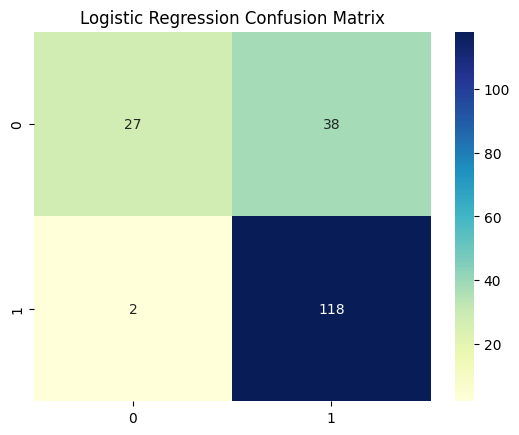

In [60]:
# Logistic Regression evaluation
y_pred_logreg = logreg.predict(X_val)
print("Logistic Regression Accuracy: ", accuracy_score(y_val, y_pred_logreg))
print("Logistic Regression Precision: ", precision_score(y_val, y_pred_logreg))
print("Logistic Regression Recall: ", recall_score(y_val, y_pred_logreg))
print("Logistic Regression F1-Score: ", f1_score(y_val, y_pred_logreg))
print("Logistic Regression AUC-ROC: ", roc_auc_score(y_val, y_pred_logreg))

# Confusion Matrix for Logistic Regression
conf_matrix_logreg = confusion_matrix(y_val, y_pred_logreg)
sns.heatmap(conf_matrix_logreg, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Logistic Regression Confusion Matrix")
plt.show()

**K-Nearest Neighbors**

KNN Accuracy:  0.6810810810810811
KNN Precision:  0.6848484848484848
KNN Recall:  0.9416666666666667
KNN F1-Score:  0.7929824561403509
KNN AUC-ROC:  0.5708333333333333


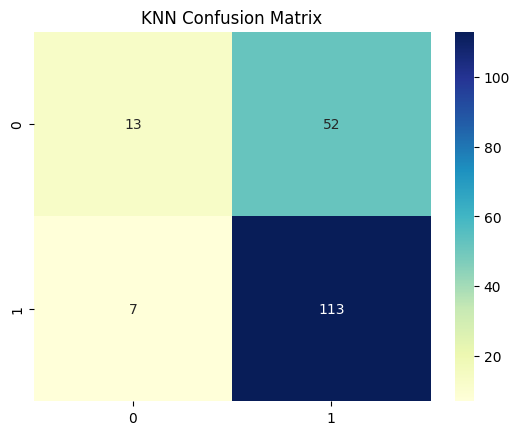

In [61]:
# KNN evaluation
y_pred_knn = knn.predict(X_val)
print("KNN Accuracy: ", accuracy_score(y_val, y_pred_knn))
print("KNN Precision: ", precision_score(y_val, y_pred_knn))
print("KNN Recall: ", recall_score(y_val, y_pred_knn))
print("KNN F1-Score: ", f1_score(y_val, y_pred_knn))
print("KNN AUC-ROC: ", roc_auc_score(y_val, y_pred_knn))

# Confusion Matrix for KNN
conf_matrix_knn = confusion_matrix(y_val, y_pred_knn)
sns.heatmap(conf_matrix_knn, annot=True, fmt="d", cmap="YlGnBu")
plt.title("KNN Confusion Matrix")
plt.show()


**Decision Tree**

Decision Tree Accuracy:  0.7027027027027027
Decision Tree Precision:  0.7480916030534351
Decision Tree Recall:  0.8166666666666667
Decision Tree F1-Score:  0.7808764940239045
Decision Tree AUC-ROC:  0.6544871794871795


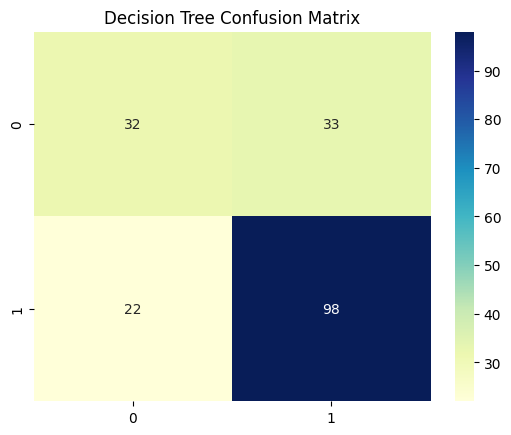

In [62]:
# Decision Tree evaluation
y_pred_dt = dt.predict(X_val)
print("Decision Tree Accuracy: ", accuracy_score(y_val, y_pred_dt))
print("Decision Tree Precision: ", precision_score(y_val, y_pred_dt))
print("Decision Tree Recall: ", recall_score(y_val, y_pred_dt))
print("Decision Tree F1-Score: ", f1_score(y_val, y_pred_dt))
print("Decision Tree AUC-ROC: ", roc_auc_score(y_val, y_pred_dt))

# Confusion Matrix for Decision Tree
conf_matrix_dt = confusion_matrix(y_val, y_pred_dt)
sns.heatmap(conf_matrix_dt, annot=True, fmt="d", cmap="YlGnBu")
plt.title("Decision Tree Confusion Matrix")
plt.show()